## 1. Import Package

In [1]:
#https://github.com/yosuah/vgg_deconv_vis/blob/master/Visualise%20convolution%20kernels.ipynb
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tic
from matplotlib.gridspec import GridSpec

import tensorflow as tf
from tensorflow.python.ops import gen_nn_ops
from tensorflow.python import control_flow_ops

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200

## 2. Load Data

In [2]:
database_path = 'Data/'
#dirname = 'ECGFiveDays_orderbysoftmax_layer3.ipynb'
dirname = 'Two_Patterns'

train_path = database_path + dirname + '/' + dirname + '_TRAIN'
test_path  = database_path + dirname + '/' + dirname + '_TEST'

train_file = np.loadtxt(train_path, delimiter=',')
test_file = np.loadtxt(test_path, delimiter=',')

#rawdata = np.concatenate((train_file, test_file))
data_train = train_file[:,1:]
labels_train = train_file[:,0].astype(int) - 1 #label starts from 0

data_test = test_file[:,1:]
labels_test = test_file[:,0].astype(int) - 1 #label starts from 0

for i in range(len(labels_train)):
    if labels_train[i] == -2 :
        labels_train[i] = 1

class_list, each_class_num = np.unique(labels_train, return_counts=True)
n_train = len(data_train)
n_class = len(class_list)
x_dim = data_train.shape[1]
labels_train = np.eye(n_class)[labels_train.astype(np.int32)]

for i in range(len(labels_test)):
    if labels_test[i] == -2 :
        labels_test[i] = 1
        
labels_test = np.eye(n_class)[labels_test.astype(np.int32)]

## 3. Define function

In [3]:
def batch_norm(x, n_out, phase_train, scope='bn'):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope(scope):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def weight_variable(shape,name):
    initial = tf.random_normal(shape, stddev=0.01)
    return tf.Variable(initial, name=name)

In [4]:
def getFilters(layer):
    print("======================= Weight Matrix")
    layer_output = layer.eval()
    print(layer_output)
    print(layer_output.shape)
    
    for i in range(layer_output.shape[1]):
        plt.imshow(layer_output[0,i,:,:], cmap="gray")
        plt.show()
        
def plotActivations(units, title):
    print("===========================", title)
    filters = units.shape[3]
    n_columns = 4
    n_rows = math.ceil(filters / n_columns) 
    
    fig, axes = plt.subplots(n_rows, n_columns, sharex=True, sharey=True, figsize=(15,n_rows*2))

    for i, ax in enumerate(axes.flatten()):
        ax.plot(units[0,0,:,i].T)
        ax.set_title('Node ' + str(i+1))
    plt.tight_layout()    
    plt.show() 
    
def plotAllActivations(units, title):
    print("===========================", title)
    plt.plot(units.squeeze())
    plt.tight_layout()    
    plt.show() 

### 4. Model

In [5]:
def deepnn(x):
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 1, x_dim, 1])

    with tf.name_scope('bn'):
        phase_train = tf.placeholder(tf.bool, name='phase_train')
            
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([1, 8, 1, 128],'W_conv1')
        C_conv1 = conv2d(x_image, W_conv1)
        B_conv1 = batch_norm(C_conv1, 128, phase_train)
        h_conv1 = tf.nn.relu(B_conv1)
        
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([1, 5, 128, 256 ],'W_conv2')
        C_conv2 = conv2d(h_conv1, W_conv2)
        B_conv2 = batch_norm(C_conv2, 256, phase_train)
        h_conv2 = tf.nn.relu(B_conv2)

    with tf.name_scope('conv3'):
        W_conv3 = weight_variable([1, 3, 256, 128],'W_conv3')
        C_conv3 = conv2d(h_conv2, W_conv3)
        B_conv3 = batch_norm(C_conv3, 128, phase_train)
        h_conv3 = tf.nn.relu(B_conv3)

    with tf.name_scope('gap'):
        n_out = int(h_conv3.shape[2]*h_conv3.shape[3])
        gap = tf.reduce_mean(h_conv3, [1,2])
        output = tf.layers.dense(gap, units=n_class, activation='softmax', name='softmax')

    return output, phase_train

In [6]:
# Create the model
x = tf.placeholder(tf.float32, [None, x_dim], name='x')
y_ = tf.placeholder(tf.float32, [None, n_class], name='y_')
phase_train =tf.placeholder(tf.bool, name='phase_train')

output, phase_train  = deepnn(x)

with tf.name_scope('loss'):
    cross_entropy = -tf.reduce_sum(y_ * tf.log(output), reduction_indices=1)
    cross_entropy = tf.reduce_mean(cross_entropy, name='reduce_mean')

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    predicted = tf.argmax(output, 1, name='predicted')
    answered = tf.argmax(y_, 1, name='answered')
    correct_prediction = tf.equal(predicted, answered)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

graph_location = 'Deconv_Timeseries/tf_log'
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())
batch_size = 100

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(300):
    
        train_step.run(feed_dict={x: data_train, y_: labels_train, phase_train:True})
            
        if epoch % 50 == 0:
            train_accuracy = accuracy.eval(
                feed_dict={x: data_train, y_: labels_train, phase_train:True})
            print('epoch %d, training accuracy %g' % (epoch, train_accuracy))

    print('test accuracy %g' % accuracy.eval(
        feed_dict={x: data_test, y_: labels_test, phase_train:False}))
    
    saver.save(sess, './tf_log/Two_Patterns')

Saving graph to: Deconv_Timeseries/tf_log
epoch 0, training accuracy 0.508
epoch 50, training accuracy 0.894
epoch 100, training accuracy 0.951
epoch 150, training accuracy 0.996
epoch 200, training accuracy 1
epoch 250, training accuracy 1
test accuracy 0.8145


In [7]:
class_list

array([0, 1, 2, 3])

In [8]:
for op in tf.get_default_graph().get_operations():
    print(str(op.name))

x
y_
phase_train
reshape/Reshape/shape
reshape/Reshape
bn/phase_train
conv1/random_normal/shape
conv1/random_normal/mean
conv1/random_normal/stddev
conv1/random_normal/RandomStandardNormal
conv1/random_normal/mul
conv1/random_normal
conv1/W_conv1
conv1/W_conv1/Assign
conv1/W_conv1/read
conv1/Conv2D
conv1/bn/Const
conv1/bn/beta
conv1/bn/beta/Assign
conv1/bn/beta/read
conv1/bn/Const_1
conv1/bn/gamma
conv1/bn/gamma/Assign
conv1/bn/gamma/read
conv1/bn/moments/mean/reduction_indices
conv1/bn/moments/mean
conv1/bn/moments/StopGradient
conv1/bn/moments/SquaredDifference
conv1/bn/moments/variance/reduction_indices
conv1/bn/moments/variance
conv1/bn/moments/Squeeze
conv1/bn/moments/Squeeze_1
conv1/bn/cond/Switch
conv1/bn/cond/switch_t
conv1/bn/cond/switch_f
conv1/bn/cond/pred_id
bn/conv1/bn/moments/Squeeze/ExponentialMovingAverage/Initializer/zeros
bn/conv1/bn/moments/Squeeze/ExponentialMovingAverage
bn/conv1/bn/moments/Squeeze/ExponentialMovingAverage/Assign
bn/conv1/bn/moments/Squeeze/Exponen

## Restore

In [9]:
sess=tf.Session()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint("./tf_log"))

INFO:tensorflow:Restoring parameters from ./tf_log/Two_Patterns


In [10]:
def get_operatioin(sequence, sequence_label):

    Conv2D_1 = g.get_operation_by_name('conv1/Conv2D').outputs[0]
    W_conv1 = g.get_operation_by_name('conv1/W_conv1').outputs[0]

    Conv2D_2 = g.get_operation_by_name('conv2/Conv2D').outputs[0]
    W_conv2 = g.get_operation_by_name('conv2/W_conv2').outputs[0]

    Conv2D_3 = g.get_operation_by_name('conv3/Conv2D').outputs[0]
    W_conv3 = g.get_operation_by_name('conv3/W_conv3').outputs[0]

    fc = g.get_operation_by_name('gap/Mean').outputs[0]
    dense = g.get_operation_by_name('gap/softmax/MatMul').outputs[0]
    Softmax = g.get_operation_by_name('gap/softmax/Softmax').outputs[0]
    softmax_kernel = g.get_operation_by_name('softmax/kernel').outputs[0]

    Conv2D_1_output,W_conv1_output,Conv2D_2_output,W_conv2_output,Conv2D_3_output,W_conv3_output,fc_output,dense_output,softmax_output,softmax_kernel_output = sess.run(
        [Conv2D_1,W_conv1,Conv2D_2,W_conv2,Conv2D_3,W_conv3,fc,dense,Softmax,softmax_kernel],feed_dict={x: sequence,y_:sequence_label, phase_train:False})        

    return Conv2D_1_output.squeeze(),W_conv1_output.squeeze(),Conv2D_2_output.squeeze(),W_conv2_output.squeeze(),\
Conv2D_3_output.squeeze(),W_conv3_output.squeeze(),fc_output.squeeze(),dense_output.squeeze(),softmax_output.squeeze(),softmax_kernel_output.squeeze()

In [11]:
n_train = len(data_train)
sum_gap = np.zeros(128)

x_arr = []
y_arr = []
conv1_arr = []
w1_arr = []
conv2_arr = []
w2_arr = []
conv3_arr = []
w3_arr = []
gap_arr = []
dense_arr = []
softmax_arr = []
sm_kernel_arr = []

In [12]:
g = tf.get_default_graph()
x = g.get_operation_by_name('x').outputs[0]
y = g.get_operation_by_name('y_').outputs[0]

In [13]:
for i in range(n_train):
    sequence = np.expand_dims(data_train[i],0)
    sequence_label = labels_train[i]
    
    Conv2D_1_output,W_conv1_output,Conv2D_2_output,W_conv2_output,Conv2D_3_output,\
        W_conv3_output,gap_output,dense_output,softmax_output,softmax_kernel_output = get_operatioin(sequence, np.expand_dims(sequence_label,0))
    
    x_arr.append(sequence)
    y_arr.append(sequence_label)
    conv1_arr.append(Conv2D_1_output)
    w1_arr.append(W_conv1_output)
    conv2_arr.append(Conv2D_2_output)
    w2_arr.append(W_conv2_output)
    conv3_arr.append(Conv2D_3_output)
    w3_arr.append(W_conv3_output)
    gap_arr.append(gap_output)
    dense_arr.append(dense_output)
    softmax_arr.append(softmax_output)
    sm_kernel_arr.append(softmax_kernel_output)
    
    #weight = sequence_label[0] * 16 + sequence_label[1] * 8 + sequence_label[2] * 4 + sequence_label[3] * 2
    #sum_gap = sum_gap + gap_output * weight

In [14]:
sequence.shape

(1, 128)

In [15]:
Conv2D_1_output.shape

(128, 128)

In [16]:
Conv2D_2_output.shape

(128, 256)

In [17]:
Conv2D_3_output.shape

(128, 128)

In [18]:
class0 = []
class1 = []
class2 = []
class3 = []
# class4 = []
# class5 = []
# class6 = []

for data_index in range(n_train):
    index = np.argmax(y_arr[data_index])
    if index == 0 :
        class0.append(data_index)
    elif index == 1 :
        class1.append(data_index)
    elif index == 2 :
        class2.append(data_index)
    elif index == 3 :
        class3.append(data_index)
#     elif index == 4 :
#         class4.append(data_index)
#     elif index == 5 :
#         class5.append(data_index)
#     elif index == 6 :
#         class6.append(data_index)

In [19]:
print(w1_arr[-1].shape)
flatten_w1 = w1_arr[-1].reshape([-1,128])
print(flatten_w1.shape)
w1_avg = np.average(flatten_w1, axis=0)
w1_index = np.argsort(-w1_avg)
print(w1_index)

(8, 128)
(8, 128)
[107 109  16  64 114 123  65  17  76  39 125  43 119  92   7  59  69  87
  52   0  29  28  72  40  83 113  67  88  97  13  14   8  94  53  22  73
  90  75  60  54  46   3  26   6 102  61 116  79  95  89  36 118  56   9
  77  66  48   1 121  71  41  68  38  12  27 112 127  93 103  74  34  10
  23   5 106 101  57  37  30  33 104 115 120  70 126   4   2  51 110  31
 122  47 111  85 100  78  44  25  49  18  96 105  62  20  50  63  84 117
  86 108  82  19 124  58  80  91  55  81  99  98  11  42  21  35  45  32
  15  24]


In [20]:
flatten_w2 = w2_arr[-1].reshape([-1,256])
w2_avg = np.average(flatten_w2, axis=0)
w2_index = np.argsort(-w2_avg)

In [21]:
flatten_w3 = w3_arr[-1].reshape([-1,128])
w3_avg = np.average(flatten_w3, axis=0)
w3_index = np.argsort(-w3_avg)

In [22]:
def show_5_vir(arr, index, start):
    plt.figure(figsize=[3,5])
    
    ax1= plt.subplot(5,1,1)
    plt.plot(arr[:,index][:,start], linewidth=4)
    
    plt.subplot(5,1,2, sharey=ax1)
    plt.plot(arr[:,index][:,start+1], linewidth=4)

    plt.subplot(5,1,3, sharey=ax1)
    plt.plot(arr[:,index][:,start+2], linewidth=4)
    
    plt.subplot(5,1,4, sharey=ax1)
    plt.plot(arr[:,index][:,start+3], linewidth=4)
    
    plt.subplot(5,1,5, sharey=ax1)
    plt.plot(arr[:,index][:,start+4], linewidth=4)
    
    plt.tight_layout()
    plt.show()

In [23]:
def show_5(arr, index, start):
    plt.figure(figsize=[10,10])
    
    ax1= plt.subplot(5,1,1)
    plt.plot(arr[:,index][:,start], linewidth=4)
    plt.subplots_adjust(hspace = .001)
    ax1.set_xticklabels(())
    ax1.title.set_visible(False)
    
    ax2= plt.subplot(5,1,2, sharey=ax1)
    plt.subplots_adjust(hspace = .001)
    ax2.set_xticklabels(())
    ax2.title.set_visible(False)
    plt.plot(arr[:,index][:,start+1], linewidth=4)

    plt.subplot(5,1,3, sharey=ax1)
    plt.subplots_adjust(hspace = .001)
    plt.xticks([])
    plt.plot(arr[:,index][:,start+2], linewidth=4)
    
    plt.subplot(5,1,4, sharey=ax1)
    plt.subplots_adjust(hspace = .001)
    plt.xticks([])
    plt.plot(arr[:,index][:,start+3], linewidth=4)
    
    plt.subplot(5,1,5, sharey=ax1)
    plt.subplots_adjust(hspace = .001)
    plt.xticks([])
    plt.plot(arr[:,index][:,start+4], linewidth=4)
    
    plt.tight_layout()
    plt.show()

In [24]:
def sticked_plot(arr, index, start):
    fig = plt.figure(figsize=[15,18])

    ax = plt.subplot(511)
    plt.plot(arr[:,index][:,start], linewidth=10)
    plt.subplots_adjust(hspace = .001)
    #plt.tick_params(labelsize = 20)
    plt.yticks([])
    plt.xticks([])
    
    for i in range(1, 4):
        temp = 511 + i
        plt.subplot(temp, sharey=ax)
        plt.plot(arr[:,index][:,start+i], linewidth=10)
        plt.subplots_adjust(hspace = .001)
        #plt.tick_params(labelsize = 20)
        plt.yticks([])
        plt.xticks([])

    plt.subplot(515, sharey=ax)
    plt.plot(arr[:,index][:,start+4], linewidth=10)
    #plt.tick_params(labelsize = 20)
    plt.yticks([])
    plt.xticks([])
    plt.subplots_adjust(hspace = .001)

    plt.show()

In [25]:
sorted_c_0 = np.argsort(-sm_kernel_arr[class0[0]][:,[0]], axis=0).squeeze() #argsort reverse order
sorted_c_1 = np.argsort(-sm_kernel_arr[class1[1]][:,[1]], axis=0).squeeze()

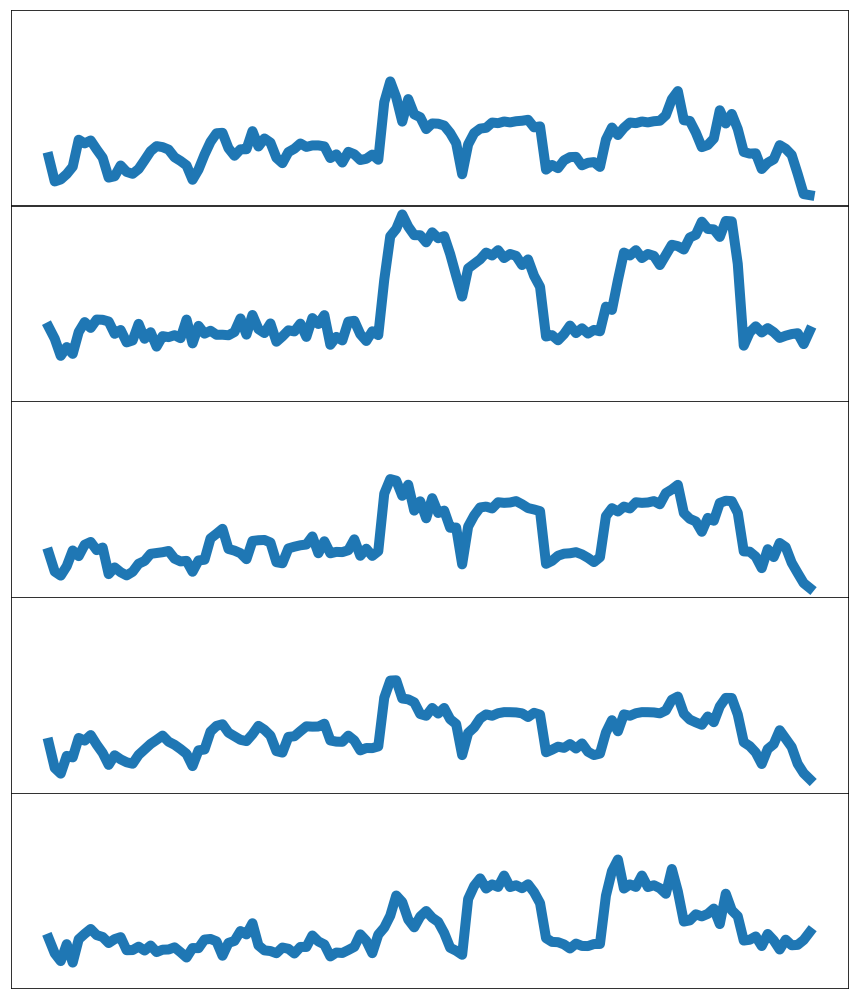

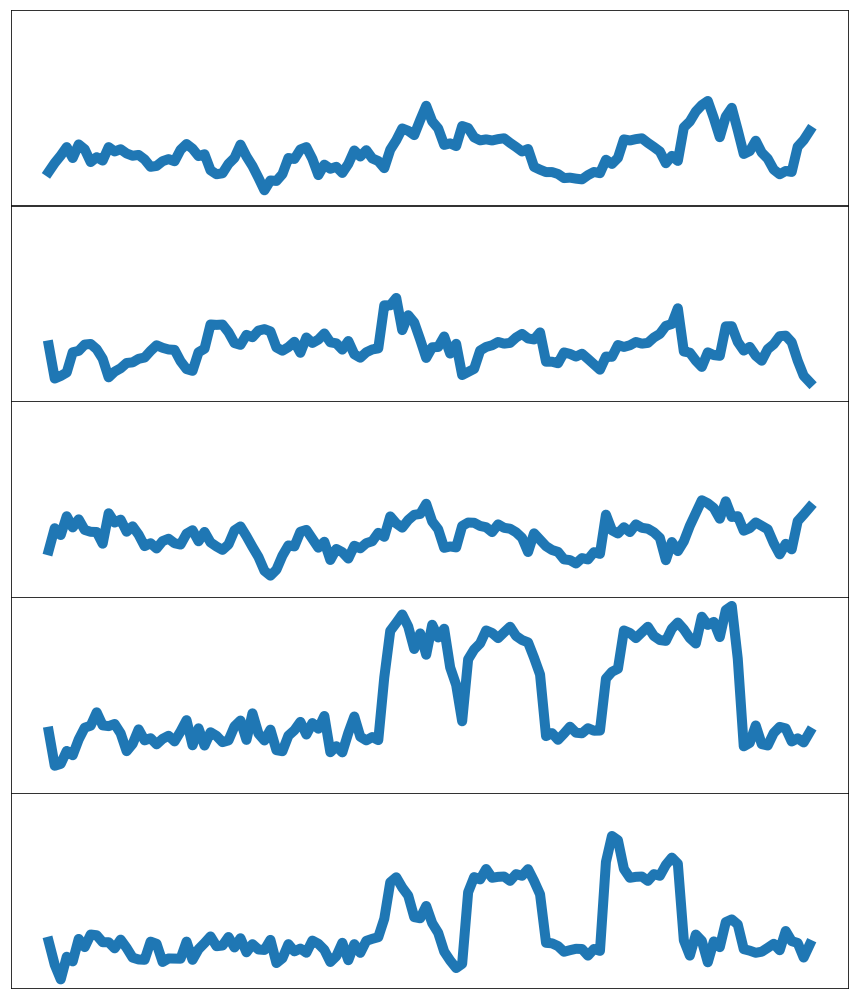

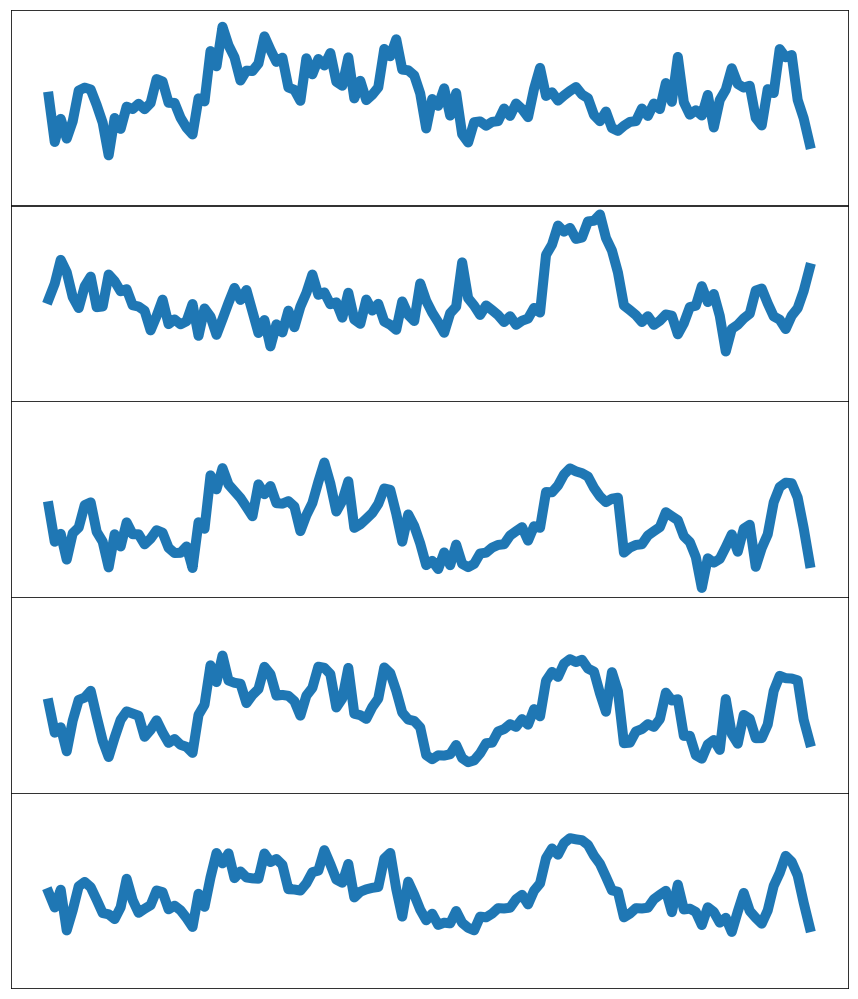

In [26]:
sticked_plot(conv3_arr[class0[0]], sorted_c_0, 0)
sticked_plot(conv3_arr[class0[0]], sorted_c_0, 30)
sticked_plot(conv3_arr[class0[0]], sorted_c_0, 100)

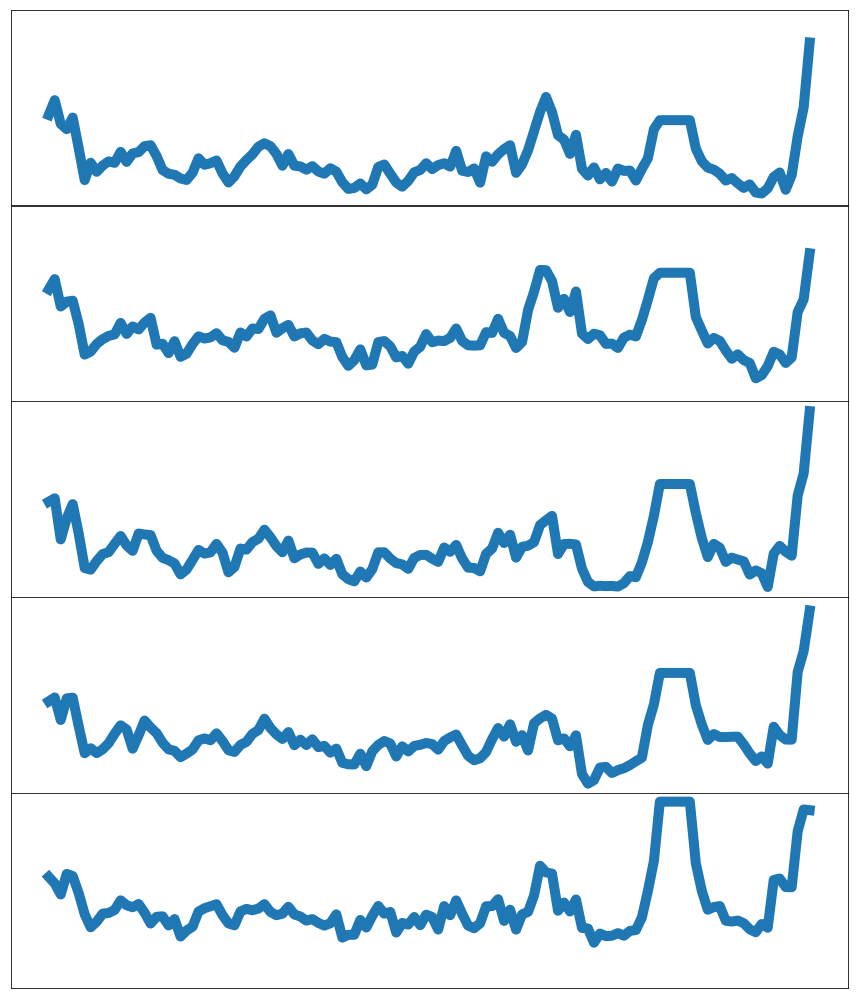

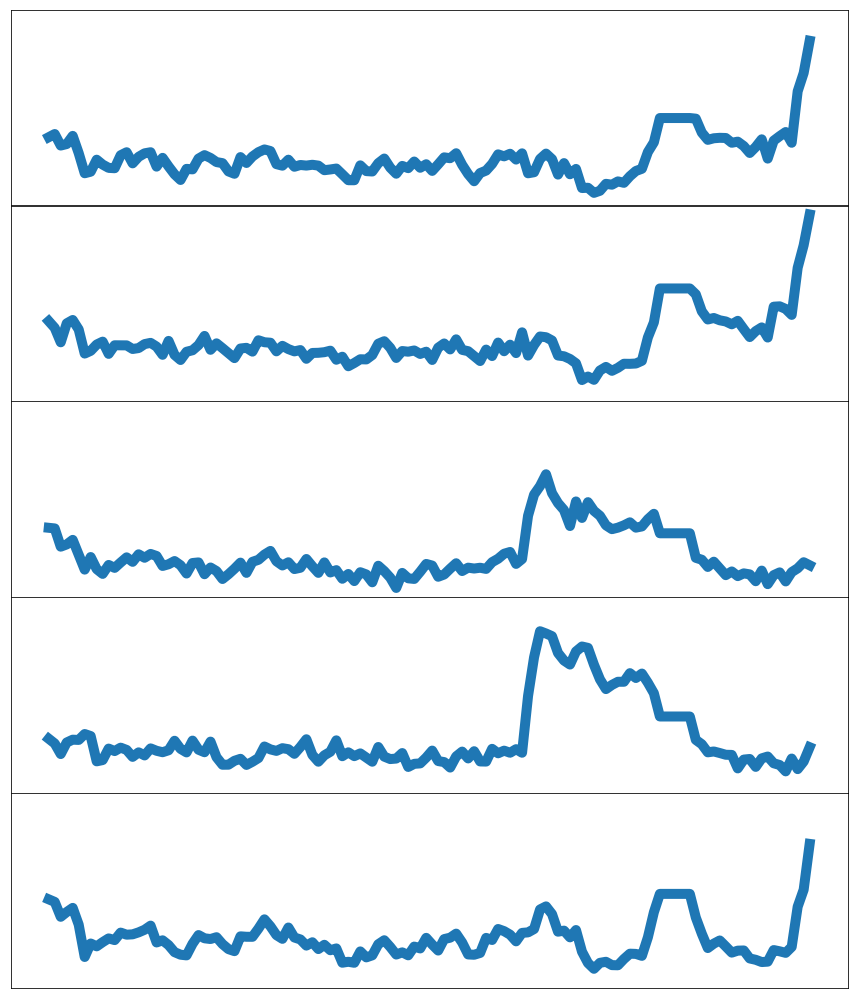

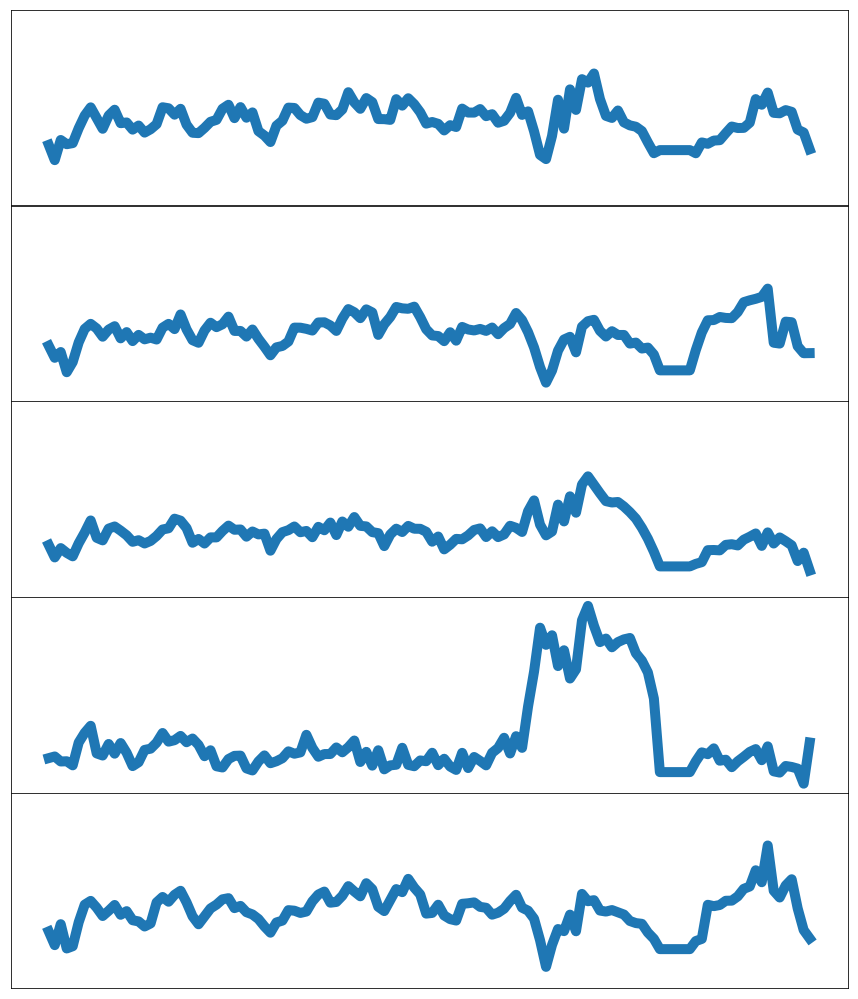

In [27]:
sticked_plot(conv3_arr[class1[1]], sorted_c_1, 0)
sticked_plot(conv3_arr[class1[1]], sorted_c_1, 30)
sticked_plot(conv3_arr[class1[1]], sorted_c_1, 100)

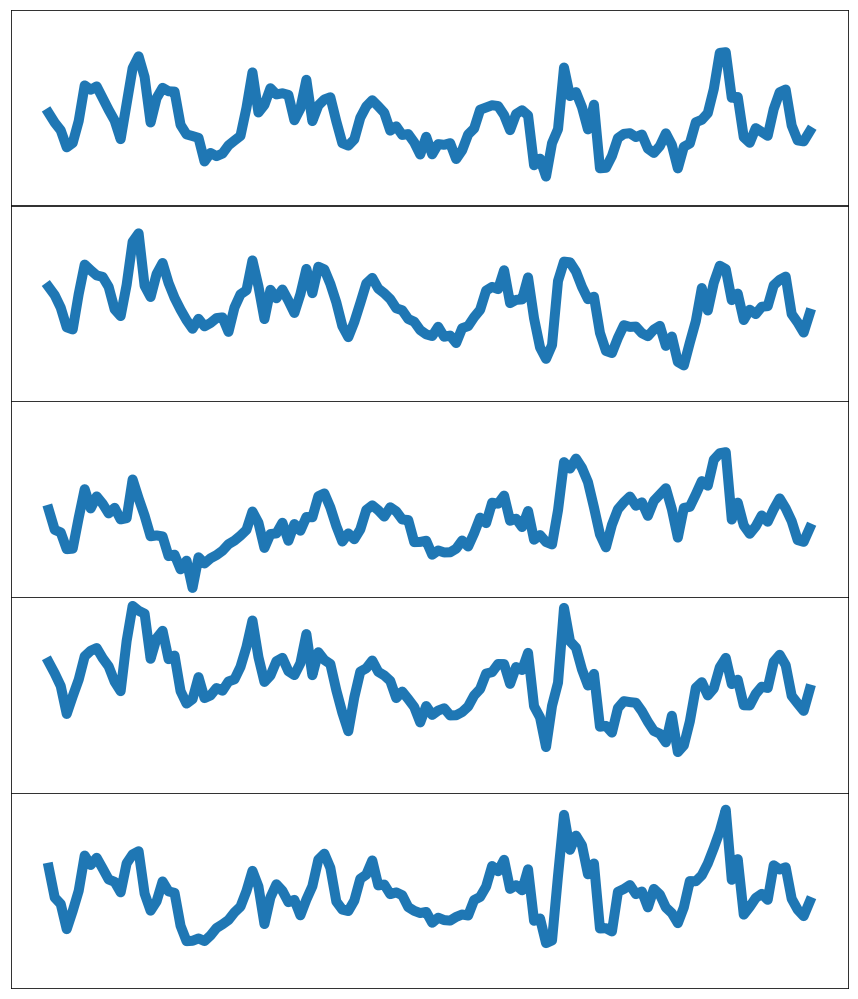

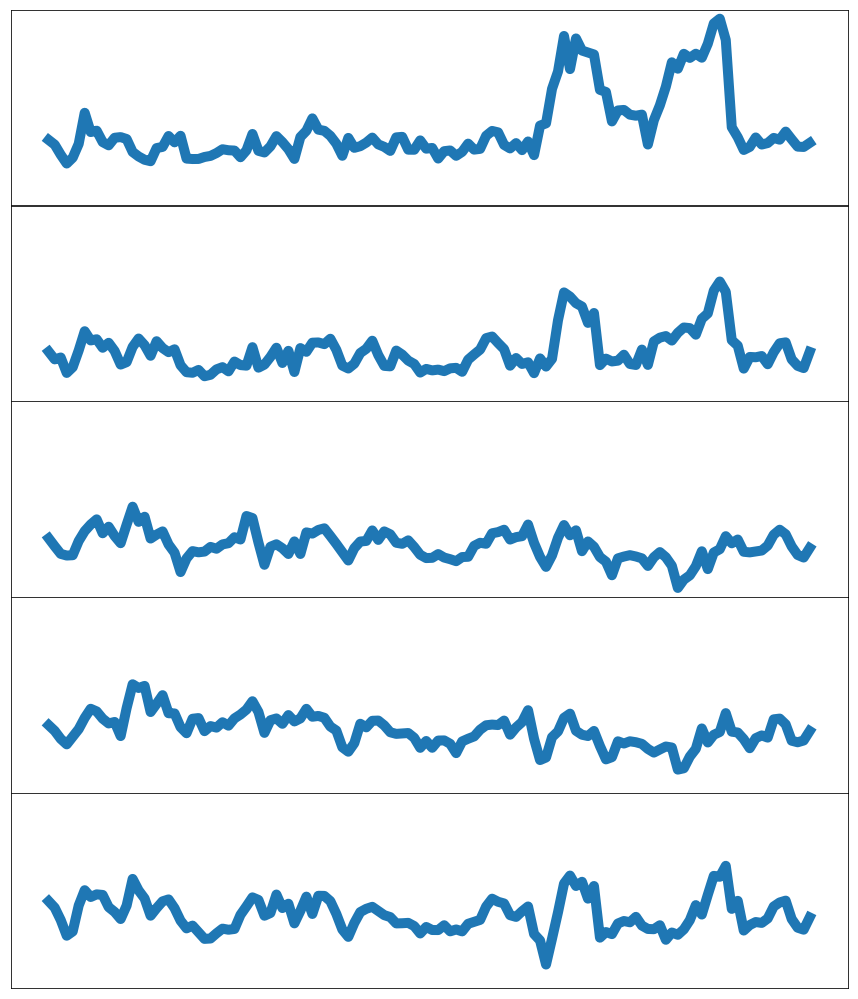

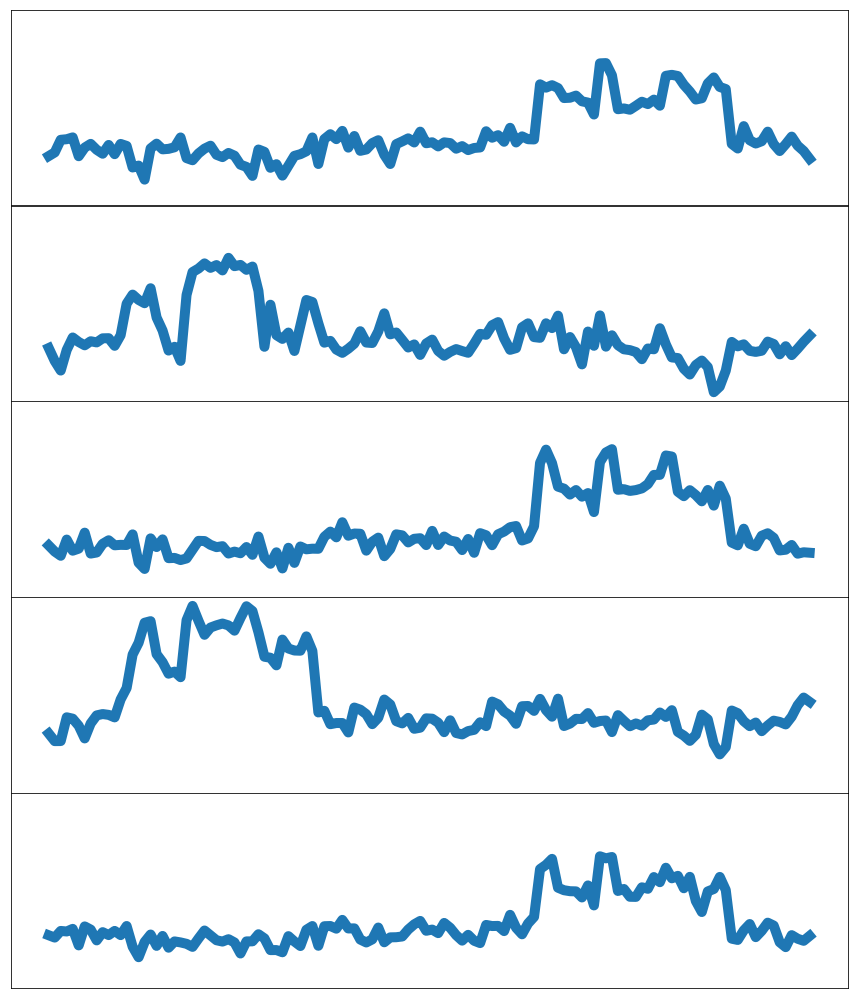

In [28]:
sorted_c_2 = np.argsort(-sm_kernel_arr[class2[2]][:,[2]], axis=0).squeeze()
sticked_plot(conv3_arr[class2[2]], sorted_c_2, 0)
sticked_plot(conv3_arr[class2[2]], sorted_c_2, 30)
sticked_plot(conv3_arr[class2[2]], sorted_c_2, 100)

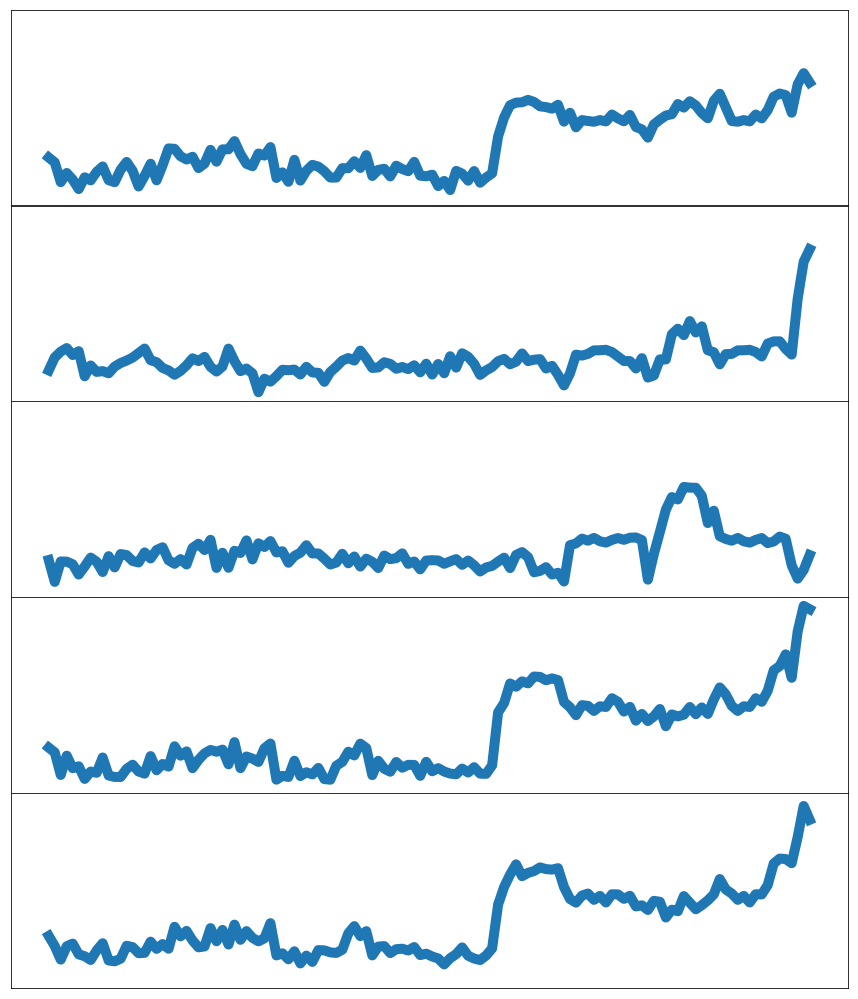

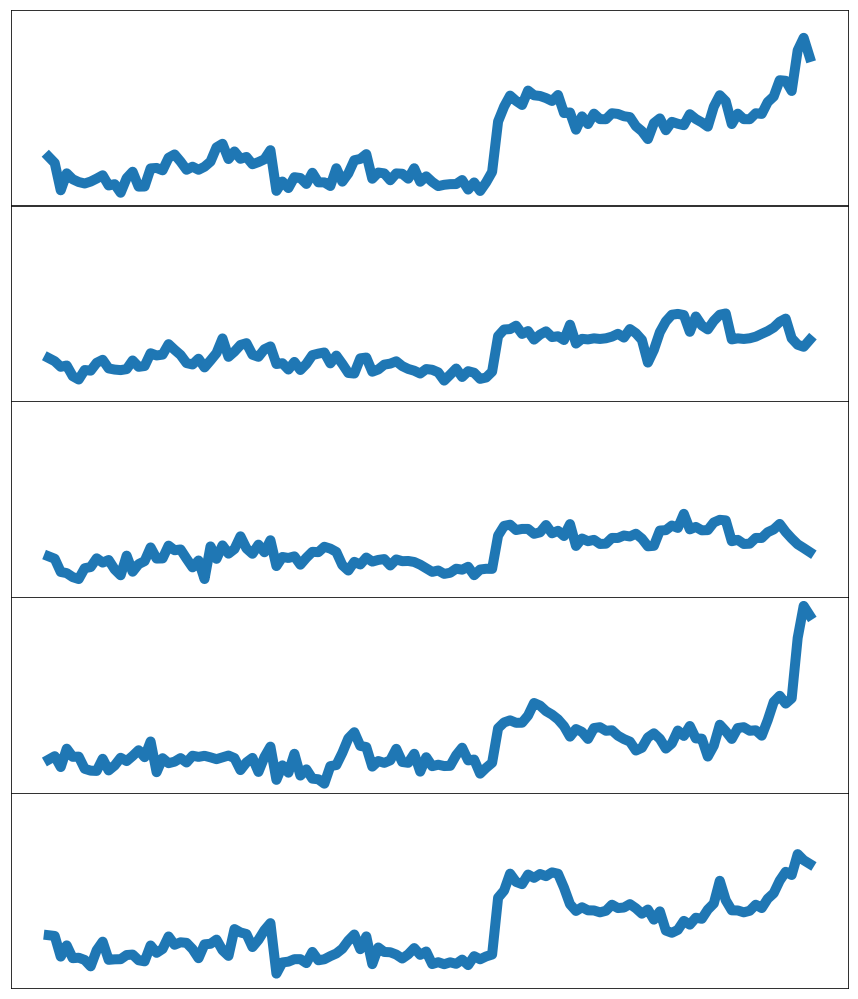

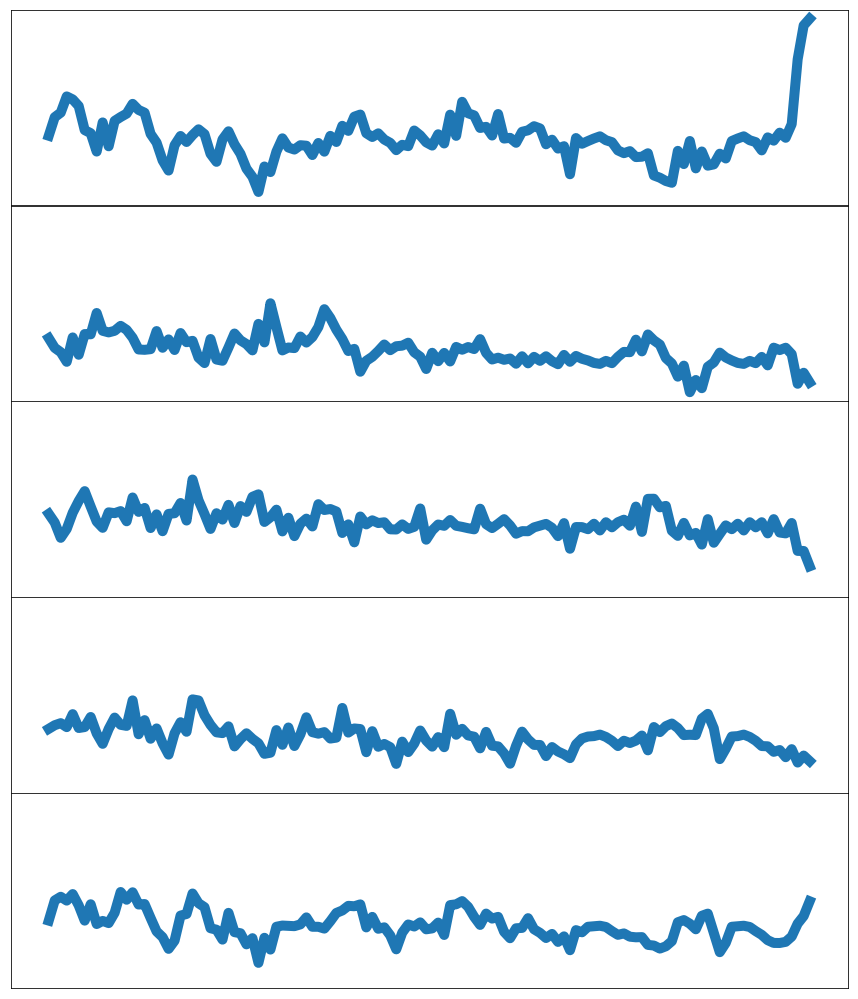

In [29]:
sorted_c_3 = np.argsort(-sm_kernel_arr[class3[3]][:,[3]], axis=0).squeeze()
sticked_plot(conv3_arr[class3[3]], sorted_c_3, 0)
sticked_plot(conv3_arr[class3[3]], sorted_c_3, 30)
sticked_plot(conv3_arr[class3[3]], sorted_c_3, 100)

## Relu Conv

In [30]:
def order_by_softmax_all(data_index, sorted_index):   
    print("True Label : ",y_arr[data_index],)
    gs = GridSpec(1,8,width_ratios=[3,0.1,3,0.1,3,0.1,3,0.3])
    fig = plt.figure(figsize=[50,10])

    ax0 = fig.add_subplot(gs[:,0])
    im1 = ax0.plot(x_arr[data_index].squeeze())
    plt.title("Input", fontsize=50)
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    
    ax1 = fig.add_subplot(gs[:,2:3])
    im1 = ax1.imshow(conv1_arr[data_index][:,sorted_index].T, cmap='coolwarm', 
               vmin = -abs(np.max(conv1_arr[data_index])), vmax=abs(np.max(conv1_arr[data_index])))
    plt.axis('auto')
    plt.title("Layer1", fontsize=50)   
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    
    ax2 = fig.add_subplot(gs[:,4:5])
    ax2.imshow(conv2_arr[data_index].T, cmap='coolwarm', 
               vmin = -abs(np.max(conv2_arr[data_index])), vmax=abs(np.max(conv2_arr[data_index])))
    plt.axis('auto')
    #plt.yticks([])
    plt.title("Layer2", fontsize=50)    
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    
    ax3 = fig.add_subplot(gs[:,6:7])
    ax3.imshow(conv3_arr[data_index][:,sorted_index].T, cmap='coolwarm', 
               vmin = -abs(np.max(conv3_arr[data_index])), vmax=abs(np.max(conv3_arr[data_index])))
    plt.axis('auto')
    #plt.yticks([])
    plt.title("Layer3", fontsize=50)  
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    
    ax4 = fig.add_subplot(gs[:,7])
    ax4.imshow(gap_arr[data_index][sorted_index, np.newaxis], cmap='coolwarm',
               vmin = -abs(np.max(gap_arr[data_index])), vmax=abs(np.max(gap_arr[data_index])))
    plt.axis('auto')
    plt.xticks([-0.5, 0.5],[0,1])
    plt.yticks([])
    plt.title("GAP", fontsize=50)
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    
    #plt.tight_layout()
    plt.show()

True Label :  [1. 0. 0. 0.]


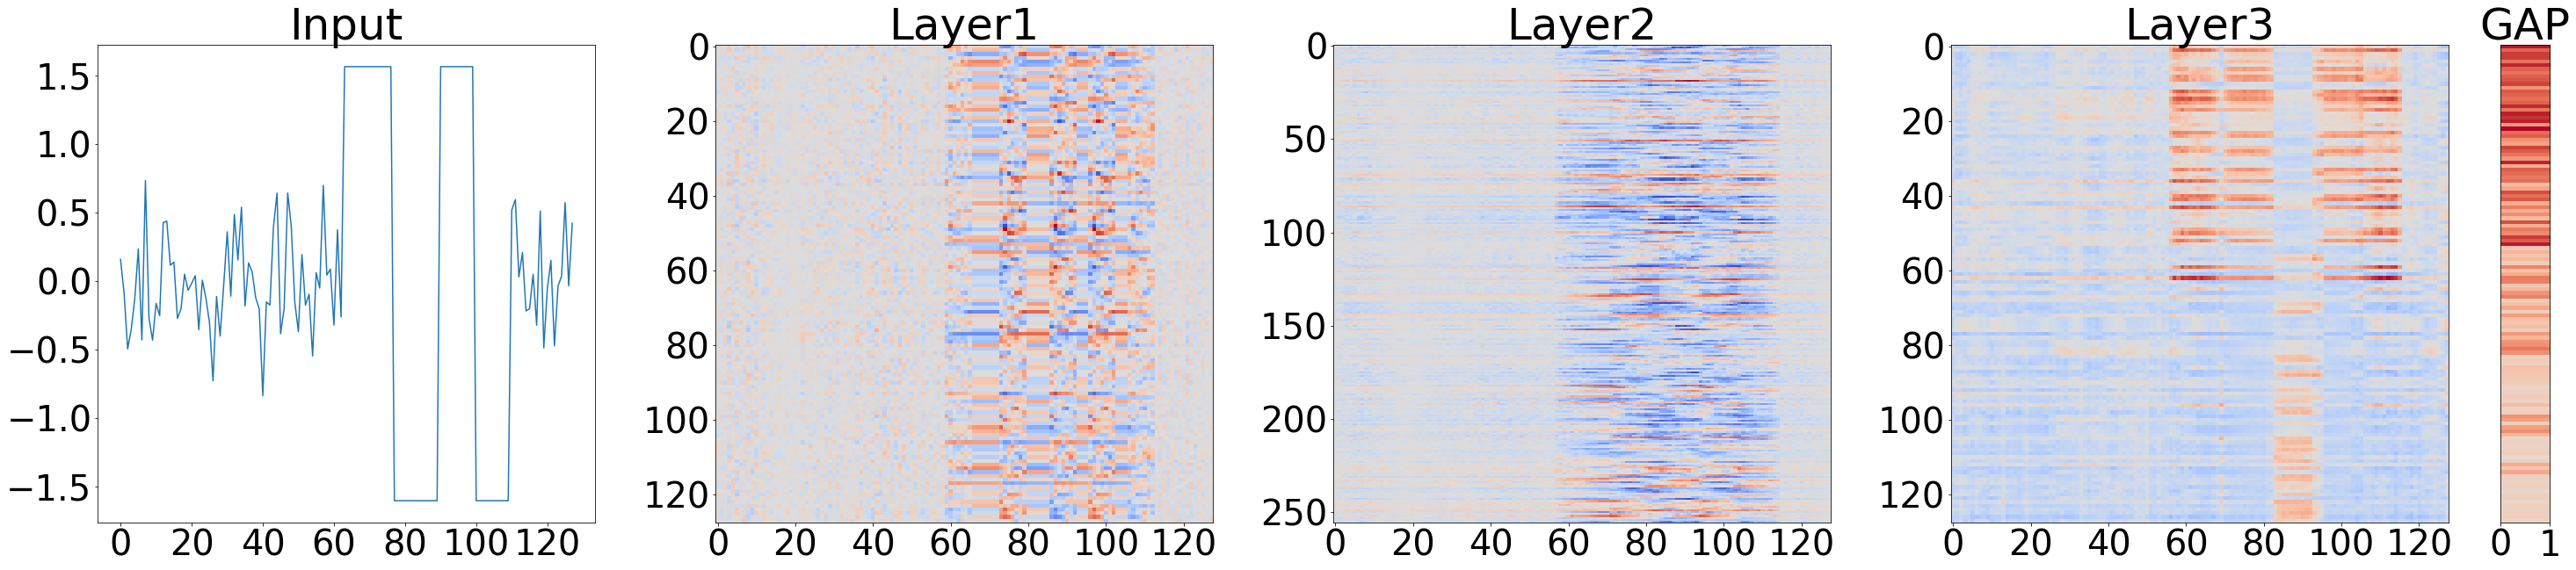

In [31]:
order_by_softmax_all(class0[0], sorted_c_0)

True Label :  [0. 1. 0. 0.]


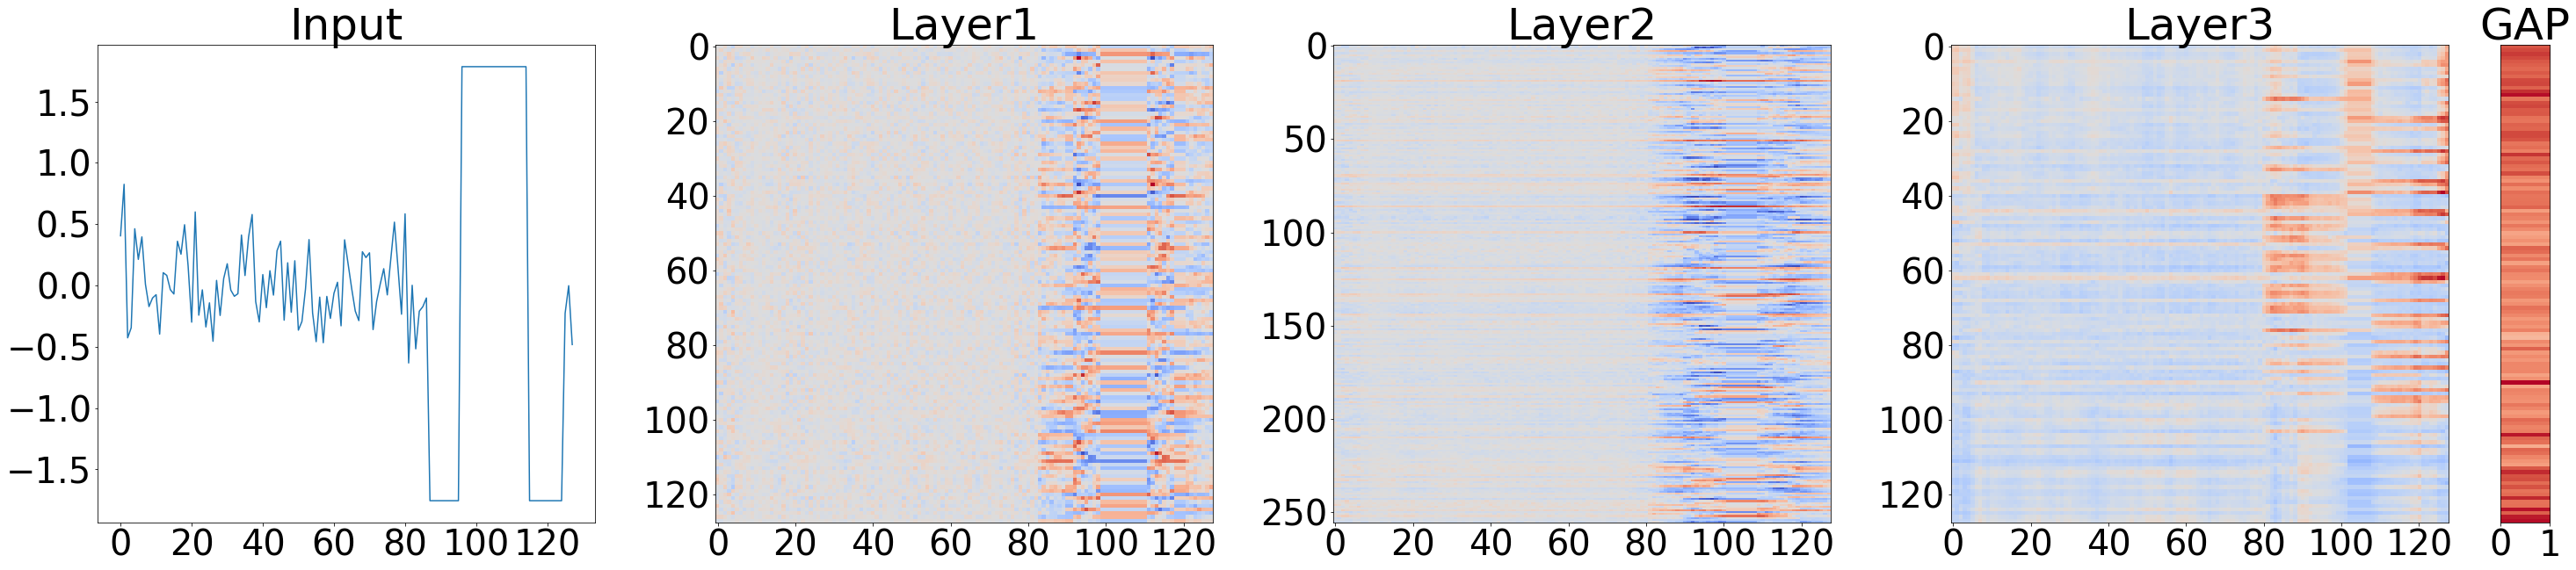

In [32]:
order_by_softmax_all(class1[1], sorted_c_1)

True Label :  [0. 0. 1. 0.]


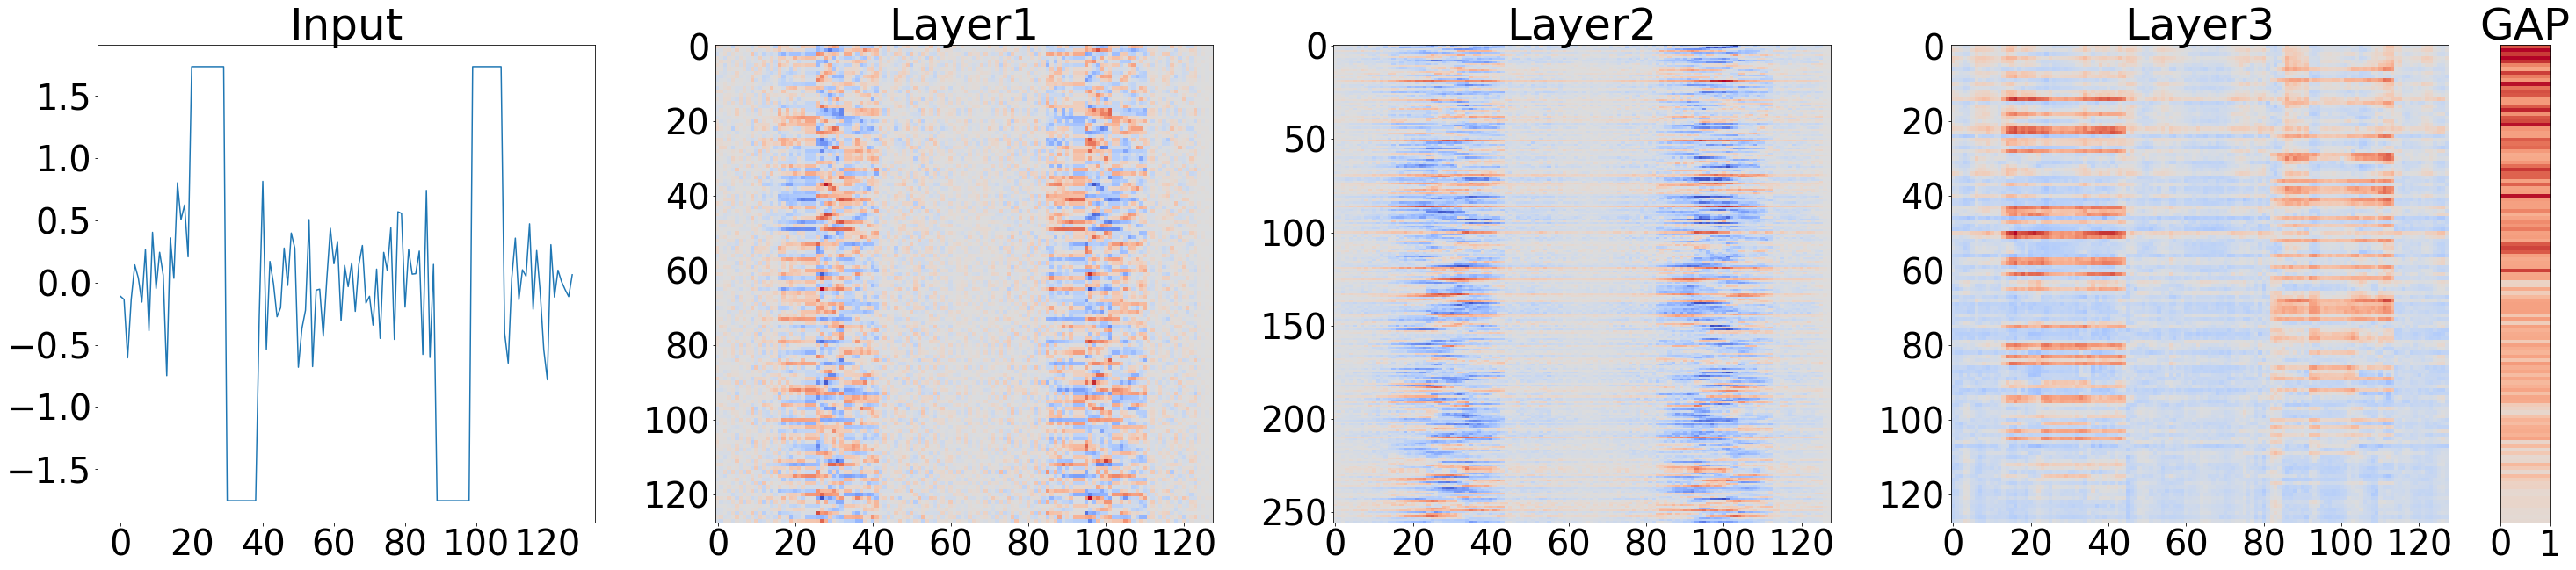

In [33]:
order_by_softmax_all(class2[2], sorted_c_2)

True Label :  [0. 0. 0. 1.]


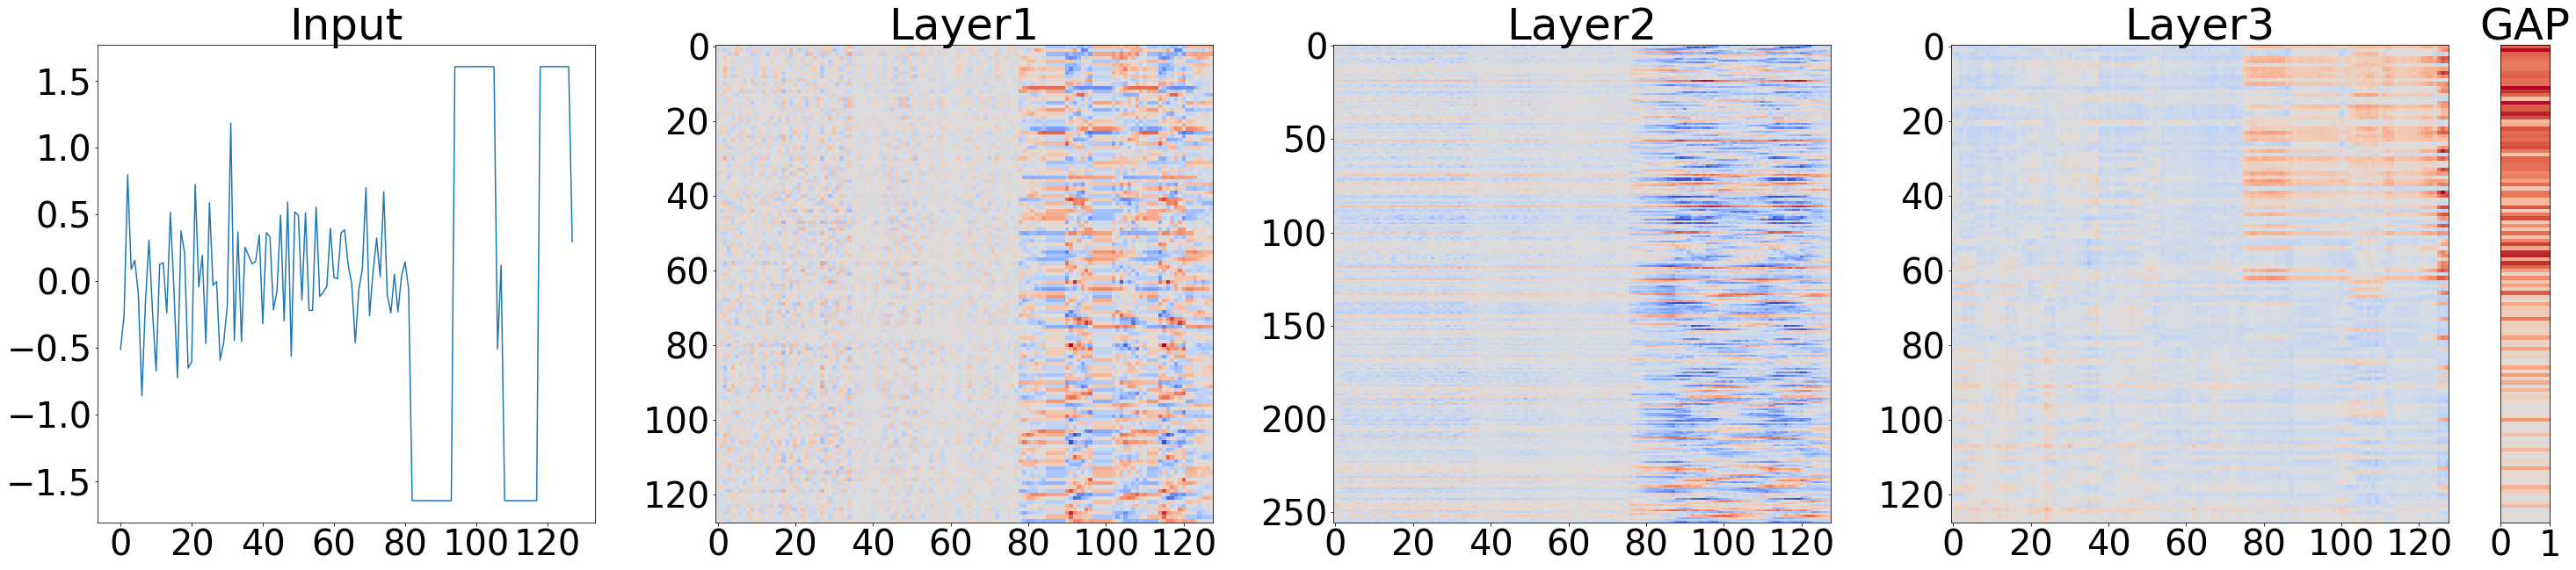

In [34]:
order_by_softmax_all(class3[3], sorted_c_3)

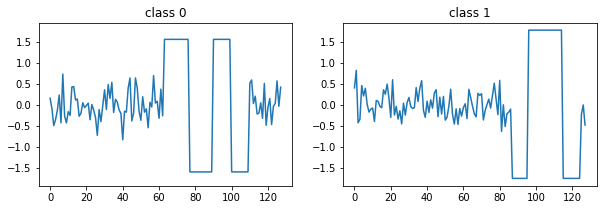

In [35]:
plt.figure(figsize=[10,3])
ax1=plt.subplot(1,2,1)
plt.plot(x_arr[class0[0]].squeeze())
plt.title("class 0")
plt.subplot(1,2,2, sharey=ax1)
plt.plot(x_arr[class1[1]].squeeze())
plt.title("class 1")
plt.show()